# Step 3: Tomogram Refinement

In [1]:
from typer_config import yaml_loader

from ddw import refine_tomogram
from ddw.utils.visualization import plot_tomo_slices
from ddw.utils.mrctools import load_mrc_data
from ddw.utils.print import pprint_dict, print_help_for_function_arguments


## Refining the Tutorial Data

The `ddw refine-tomogram` produces the final denoised and missing-wedge-corrected tomogram(s) using the model we fitted in Step 2.

In [2]:
!conda run -n ddw_env ddw refine-tomogram --config ./config.yaml

Saving refined tomogram to tutorial_project/refined_tomograms/tomo_even_frames+tomo_odd_frames_refined.mrc

Refining tomo0:   0%|          | 0/54 [00:00<?, ?it/s]/opt/conda/envs/ddw_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(
Refining tomo1: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s]



Let's have a look at the FBP reconstruction and the tomogram refined with DeepDeWedge:

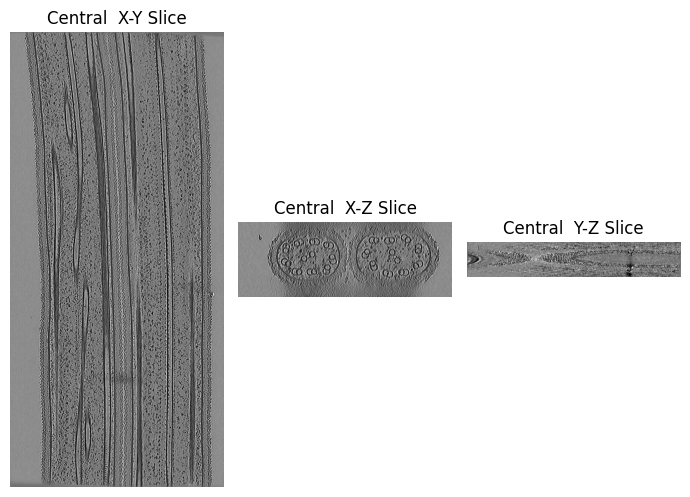

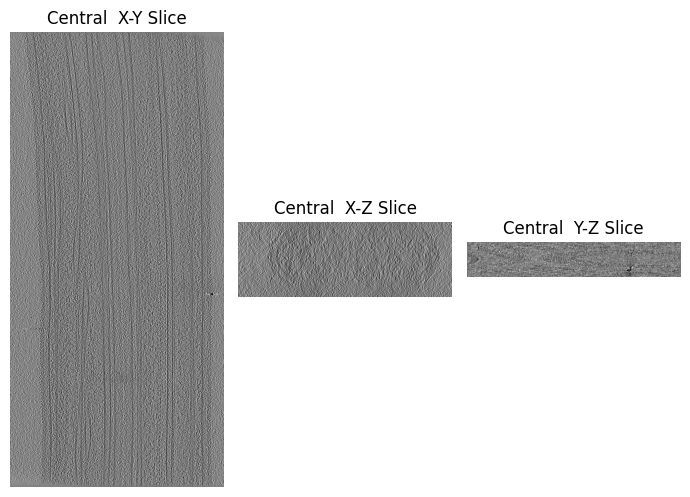

In [5]:
tomo_ref = load_mrc_data("./tutorial_project/refined_tomograms/tomo_even_frames+tomo_odd_frames_refined.mrc")
plot_tomo_slices(tomo_ref.clamp(-3*tomo_ref.std(), 3*tomo_ref.std())).show()

tomo_ref = load_mrc_data("./tutorial_data/tomo_full.mrc")
plot_tomo_slices(tomo_ref.clamp(-3*tomo_ref.std(), 3*tomo_ref.std())).show()

## Most Important Parameters of `refine-tomogram` 

You can find a full list of parameters for `ddw refine-tomogram` by executing
```
conda run -n ddw_env ddw refine-tomogram --help
```
in the commandline. Here, we only discuss the most important parameters. The required parameters, which cover the most relevant functionality for most users, are:

In [11]:
print_help_for_function_arguments(refine_tomogram, print_only_required=True)

ARGUMENT 'tomo0_files'
	REQUIRED: True
	HELP: List of paths to tomograms (mrc files) reconstructed from one half of the tilt series or movie frames.
ARGUMENT 'tomo1_files'
	REQUIRED: True
	HELP: List of paths to tomograms (mrc files) reconstructed from the other half of the tilt series or movie frames.
ARGUMENT 'model_checkpoint_file'
	REQUIRED: True
	HELP: Path to a model checkpoint file (.ckpt extension). Checkpoints saved during model fitting can be found in the 'logdir' directory specifed for the 'fit-model' command.
ARGUMENT 'subtomo_size'
	REQUIRED: True
	HELP: Size of the cubic subtomograms to extract. This should be the same as the subtomo_size used during model fitting.


Model checkpoints can be found in the logging directory used during `ddw fit-model`, which is typically `{project_dir}/logs`. In this concrete case, the `tutorial_project/logs` directory contains model checkpoints for various epochs, as well as those achieving the lowest validation and fitting losses. The frequency and number of checkpoints created is controlled by arguments during model fitting, see `ddw fit-model --help` for more information. 

**Note:** In general, using the checkpoint at the latest epoch should be OK, but trying out the checkpoints with the lowest fitting and validation losses may lead to better results. So far, we have not seen significant differences between the different checkpoints in our tests.

## A Note on Normalization

To improve performance and stability of DeepDeWedge, we normalize the full FBP reconstructions with the mean and variance of the model input sub-tomograms during model fitting.

Even though we progressively fill in the missing wedges of the model input sub-tomograms $\{{\color{red}\tilde{\mathbf{v}}^0_{\color{white}i}}\}_{i=1}^N$ during model fitting, we found that the mean and especially the variance of these model inputs  is not necessarily the same as the mean and variance of the FBP reconstructions which have only the original missing wedge. To ensure that the data during tomogram refinement is in the same range as the data during model fitting, we re-normalize the full FBP reconstruction with the mean and variance calculated from model input sub-tomograms during model fitting, i.e.

$$
    \mu = \frac{1}{N}\sum_{i=1}^N \text{mean}\big({\color{red}\tilde{\mathbf{v}}^0_{\color{white}i}}\big), 
    \quad \sigma^2 = \frac{1}{N}\sum_{i=1}^N \text{var}\big({\color{red}\tilde{\mathbf{v}}^0_{\color{white}i}}\big)
$$,

Normalizing the sub-tomograms rather than the full FBP reconstructions during refinement led to tiling artifacts in the final tomograms.



If you apply DeepDeWedge to a set of tomograms rather than a single one, the mean and variance of the individual tomograms may vary. For this case, we added an option to re-compute model-input statistics for each tomogram individually:


In [3]:
print_help_for_function_arguments(refine_tomogram, ["recompute_normalization"])

ARGUMENT 'recompute_normalization'
	REQUIRED: False
	DEFAULT: True
	HELP: Whether to recompute the normalization values applied to the input tomograms. If `False`, the mean and variance of model inputs calculated during model fitting will be used. If `True`, the average model input mean and variance will be computed for each tomogram individually. We recommend setting this to to `True`. If you apply a model to a tomogram that was not used for model fitting or if the means and variances of the tomograms during model fitting are considerably different, recomputing the normalization is expected to be very beneficial for tomogram refinement.
